# Z-Mass peak with Spark


Start a Spark session loading spark-root and histogrammar

In [14]:
# Start up Spark (only needs to be done once)
import os
import pyspark.sql
import sys
session = pyspark.sql.SparkSession.builder \
    .appName("pyspark-zpeak") \
    .master("spark://10.64.22.66:7077") \
    .config('spark.jars.packages') \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.13,org.diana-hep:histogrammar-sparksql_2.11:1.0.4',) \
    .config('spark.cores.max',3,) \
    .getOrCreate()
sc = session.sparkContext
sqlContext = session

# Define the list of samplels

Use a python dictionary to store the sample name, file and related quantities (x-section, overall weight, line color, etc) 

In [15]:
LUMI = 35900 # in pb

###
BASE       = 'NANO_Prod/'

####
samples = {    
    'SingleMuon' : {
         'filename' : 'SingleMuonRun2016C-03Feb2017-v1.root',   
         'xsec'     : 1.,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'black',   
        },
    'DYJetsToLL' : {
         'filename' : 'DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_ext1-v2.root',   
         'xsec'     : 3.*1921.8,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'green',   
        },
    'TT' : {
         'filename' : 'TT_TuneCUETP8M2T4_13TeV-powheg-pythia8-v1.root',   
         'xsec'     : 831.76,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'gold',   
        },
    'WW' : {
         'filename' : 'WW_TuneCUETP8M1_13TeV-pythia8-v1.root',   
         'xsec'     : 118.7,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'blue',   
        },
    'WZ' : {
         'filename' : 'WZ_TuneCUETP8M1_13TeV-pythia8-v1.root',   
         'xsec'     : 47.2,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'mediumblue',   
        },
    'ZZ' : {
         'filename' : 'ZZ_TuneCUETP8M1_13TeV-pythia8-v1.root',   
         'xsec'     : 16.6,   
         'eff'      : 1.,   
         'kfactor'  : 1.,   
         'weight'   : 1.,   
         'color'    : 'darkblue',   
        },   
}


# Create DATA/MC DataFrames

Create 1 dataframe list for Data and MC appending colums with global information as samplenames and xsections to the dataframes using lit().

In [16]:
import json
from pyspark.sql.functions import lit


DFList = []

for s in samples:   
    print s
    dsPath = "hdfs://10.64.22.72:9000/"+BASE+samples[s]['filename']
    tempDF = session.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("xsec", lit(samples[s]['xsec']))\
                .withColumn("eff", lit(samples[s]['eff']))\
                .withColumn("kfactor", lit(samples[s]['kfactor']))\
                .withColumn("weight", lit(samples[s]['weight']))\
                .withColumn("sample", lit(s))        
    nev = tempDF.count()
    if samples[s]['xsec'] == 1.:        
        DFList.append([tempDF.withColumn("nevents",lit(nev))])        
    else:       
        samples[s]['weight'] = samples[s]['xsec'] * samples[s]['eff'] * samples[s]['kfactor'] * LUMI / nev
        DFList.append([tempDF.withColumn("nevents",lit(nev))])        
        
print "DFList size =", len(DFList)

print "done"

TT
WW
SingleMuon
ZZ
DYJetsToLL
WZ
DFList size = 6
done


# Reduce and Combine DataFrames

Reduce the dataframe to have a smaller number of columns (from here one can also drop the dataframes into Avro/Parquet format).

Then, merge MC and DATA dataframes into one single dataframe.

This intermediate step is needed because joining dataframes won't work if schema is different across the various dataframes.

In [17]:
mycolumns = [
    ###
    "Muon_pt",
    "Muon_eta",
    "Muon_phi",
    "Muon_mass",
    "Muon_charge",
    "Muon_dxy_ugo",
    "Muon_pfRelIso04_all",
    "Muon_pfRelIso03_all",    
    "Muon_highPtId",
    "Muon_isPFcand",
    "Muon_mediumId",
    "Muon_softId",
    "Muon_tightId",
    "nMuon",
    ###
    "Electron_pt",
    "Electron_eta",
    "Electron_phi",
    "Electron_mass",
    "Electron_charge",
    "Electron_dxy_ugo",
    "Electron_pfRelIso03_all",    
    "Electron_eCorr",
    "Electron_cutBased",
    "nElectron",
    ###
    "nFatJet",
    "FatJet_btagCMVA",
    "FatJet_btagCSVV2",
    "FatJet_btagDeepB",
    "FatJet_btagHbb",
    "FatJet_eta",
    "FatJet_mass",
    "FatJet_msoftdrop",
    "FatJet_n2b1",
    "FatJet_n3b1",
    "FatJet_phi",
    "FatJet_pt",
    "FatJet_tau1",
    "FatJet_tau2",
    "FatJet_tau3",
    "FatJet_tau4",
    "FatJet_subJetIdx1",
    "FatJet_subJetIdx2",
    ###
    "nJet",
    "Jet_btagCMVA",
    "Jet_btagCSVV2",
    "Jet_btagDeepB",
    "Jet_eta",
    "Jet_mass",
    "Jet_phi",
    "Jet_pt",
    "Jet_electronIdx1",
    "Jet_electronIdx2",
    "Jet_jetId",
    "Jet_muonIdx1",
    "Jet_muonIdx2",
    "Jet_nConstituents",
    ###
    "MET_phi",
    "MET_pt",
    "MET_significance",
    "MET_sumEt",
    ###
    "nSubJet",
    "SubJet_btagCMVA",
    "SubJet_btagCSVV2",
    "SubJet_btagDeepB",
    "SubJet_eta",
    "SubJet_mass",
    "SubJet_n2b1",
    "SubJet_n3b1",
    "SubJet_phi",
    "SubJet_pt",
    "SubJet_tau1",
    "SubJet_tau2",
    "SubJet_tau3",
    "SubJet_tau4",
    ###
    "nTau",
    "nPhoton",
    ###
    "HLT_IsoMu24",
    "HLT_IsoMu27",
    "HLT_Mu50",
    "HLT_TkMu50",
    ###
    "xsec",
    "eff",
    "kfactor",
    "nevents",
    "weight",
    "sample",
]


DF = None
if DFList:
    DF = DFList[0][0].select(*mycolumns)
    for x in DFList[1:]:
        DF = DF.union(x[0].select(mycolumns))
    print "Partitions:  %d" % DF.rdd.getNumPartitions()


Partitions:  18


# Inspect DataFrame

Quick inspections of the DF

In [18]:
DF.select("Muon_pt", "Muon_eta", "Muon_phi").show(5, truncate = False)

+---------------------------------+-----------------------------------+------------------------------------+
|Muon_pt                          |Muon_eta                           |Muon_phi                            |
+---------------------------------+-----------------------------------+------------------------------------+
|[]                               |[]                                 |[]                                  |
|[21.490677]                      |[0.70581055]                       |[-2.6748047]                        |
|[11.1236105, 9.670298, 3.6050043]|[1.4187012, -0.14077759, 2.2949219]|[2.9506836, 0.3685913, -0.017402649]|
|[26.88115]                       |[-0.058418274]                     |[0.69506836]                        |
|[95.00175, 9.536867]             |[0.0014092922, -0.5196533]         |[-1.0014648, 0.21258545]            |
+---------------------------------+-----------------------------------+------------------------------------+
only showing top 5 

# Define a Z-->m+m- User Defined Function (UDF)

UDFs can be used for transformations that are more complex than can be expressed with `where()` and friends.

For each row in the input DF, Spark will call your UDF and pass in the columns you request. The return value is added as a new column in the output DF.

Spark doesn't support having a single UDF fill multiple columns, so we have to pack multiple values into a single column.

## Define the structure of the dimuon candidate

In this example, the dimuon candidate structure will contain a boolean (passing/failing the dimuon selection), and the main dimuon candidate quantities

In [19]:
# Z->mm candidate structure

from pyspark.sql.types import *

schema = StructType([
    StructField("pass", BooleanType(), False), # True if filled / False if default(empty) 
    StructField("mass", FloatType(), False), # Z mass
    StructField("pt", FloatType(), False), # Z pt
    StructField("eta", FloatType(), False), # Z eta
    StructField("phi", FloatType(), False), # Z phi
    StructField("mu1_pt", FloatType(), False), # leading mu pT 
    StructField("mu2_pt", FloatType(), False), # sub-leading mu pT 
    StructField("mu1_eta", FloatType(), False), # leading mu eta
    StructField("mu2_eta", FloatType(), False), # sub-leading mu eta
    StructField("mu1_phi", FloatType(), False), # leading mu phi
    StructField("mu2_phi", FloatType(), False), # sub-leading mu phi
    StructField("mu1_charge", FloatType(), False), # leading mu charge 
    StructField("mu2_charge", FloatType(), False), # sub-leading mu charge 
    StructField("dPhi", FloatType(), False), # mu1,mu2 DeltaPhi
    StructField("dEta", FloatType(), False), # mu1,mu2 DeltaEta
    StructField("dR", FloatType(), False), # mu1,mu2 DeltaR
])

## Define the math of the UDF

Helper functions like deltaPhi and deltaR could be moved elsewhere (e.g. defining a helper module).

Dimuon pair is selected if (sub)leading muons is > 30(10) GeV and |eta| < 2.4.
Both muons must pass the MediumID WP.
Leading and subleading muons must be of opposite charge.

In [20]:
from math import *

# helper functions
def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

# default class implementation
ZmmFalse = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
def ZmmFunction(pt,eta,phi,charge,mass,medium):
    passes = True
    if len(pt) < 2:
        return muonTestFalse
    
    leadingIdx = None
    trailingIdx = None
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.4 and medium[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and (medium[idx]):
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and medium[idx]:
                return muonTestFalse
    
    if leadingIdx != None and trailingIdx != None and charge[leadingIdx]!=charge[trailingIdx]:
        
        mass1 = mass[leadingIdx]
        pt1 = pt[leadingIdx]
        phi1 = phi[leadingIdx]
        eta1 = eta[leadingIdx]
        theta1 = 2.0*atan(exp(-eta1))
        px1 = pt1 * cos(phi1)
        py1 = pt1 * sin(phi1)
        pz1 = pt1 / tan(theta1)
        E1 = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)
        
        mass2 = mass[trailingIdx]
        pt2 = pt[trailingIdx]
        phi2 = phi[trailingIdx]
        eta2 = eta[trailingIdx]
        theta2 = 2.0*atan(exp(-eta2))
        px2 = pt2 * cos(phi2)
        py2 = pt2 * sin(phi2)
        pz2 = pt2 / tan(theta2)
        E2 = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)
        
        
        themass = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
        thept = sqrt((px1 + px2)**2 + (py1 + py2)**2)
        thetheta = atan( thept / (pz1 + pz2) )        
        theeta = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
        thephi = asin((py1 + py2)/thept)
                
        delPhi = deltaPhi(phi[leadingIdx],phi[trailingIdx])
        delR = deltaR(eta[leadingIdx],phi[leadingIdx],eta[trailingIdx],phi[trailingIdx])
        delEta = eta[leadingIdx]-eta[trailingIdx]
        
        return (True, 
                themass, thept, theeta, thephi, 
                pt[leadingIdx], pt[trailingIdx],
                eta[leadingIdx], eta[trailingIdx],
                phi[leadingIdx], phi[trailingIdx],
                charge[leadingIdx], charge[trailingIdx],
                delPhi, delR, delEta
               )
    else:
        return ZmmFalse    

## Test the UDF

Pass a pair of muons to the UDF to test the behaviour.

In [21]:
# Some example muons to test we get the right thing from our UDF
# This should pass
print ZmmFunction([52.707950592041016, 35.526939392089844],
                 [0.24396079778671265, -0.08245399594306946],
                 [-0.8336199522018433, 2.2777249813079834],
                 [1.0, -1.0],
                 [0.100, 0.100],
                 [True, True])
# This should fail
print ZmmFunction([52.707950592041016, 5.526939392089844],
                 [0.24396079778671265, -0.08245399594306946],
                 [-0.8336199522018433, 2.2777249813079834],
                 [1.0, -1.0],
                 [0.100, 0.100],
                 [True, True])    

(True, 87.69167127931945, 17.230793923039208, 0.5546137602058708, -0.771223374413431, 52.707950592041016, 35.526939392089844, 0.24396079778671265, -0.08245399594306946, -0.8336199522018433, 2.2777249813079834, 1.0, -1.0, -3.1113449335098267, 3.128420354243164, 0.3264147937297821)
(False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Create a 'Z-->mm candidate' column using the UDF

Apply the UDF (equivalent to looping within a row) and create a 'Z-->mm candidate' structure in the DF

In [34]:
# Convert the python function to a Spark UDF
from pyspark.sql.functions import udf
ZmmUDF = udf(ZmmFunction, schema)
# Make a new column and fill it with the results of muonUDF
ZmmDF = DF.withColumn("Zmm", ZmmUDF("Muon_pt", 
                                         "Muon_eta",
                                         "Muon_phi",
                                         "Muon_charge",
                                         "Muon_mass",
                                         "Muon_mediumId")
                         )


# Check events passing the Z-->mm UDF

UDF sets `flat.pass` to `False` for events that fail dimuon cuts.


In [23]:
ZmmDF.filter("Zmm.pass").select("sample","Zmm").show(2, truncate = False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|sample|Zmm                                                                                                                                                      |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|TT    |[true,144.83916,124.13932,-0.19060248,0.2909783,135.60971,49.35242,-0.27734375,0.28564453,2.4785156,-1.8173828,null,null,-1.9872869,2.0654938,-0.5629883]|
|TT    |[true,71.81045,107.88356,1.3385386,-1.1175364,86.59694,30.364235,1.4689941,0.4281006,-1.7995605,-2.711914,null,null,0.9123535,1.3841417,1.0408936]       |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 row

# Plot Zmm-related variables

Use Matplotlib and Histogrammar to create plots starting from the whole dataframe (i.e. un-weighted mix of data and MC)

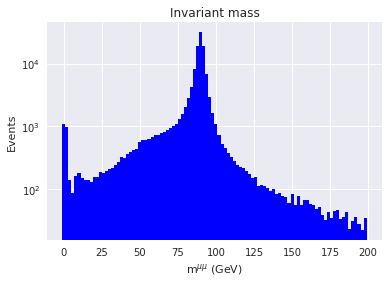

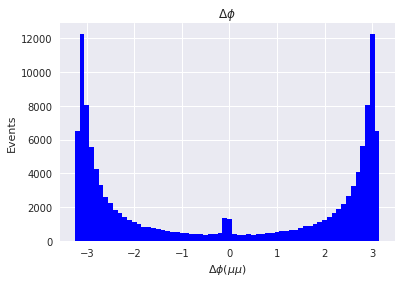

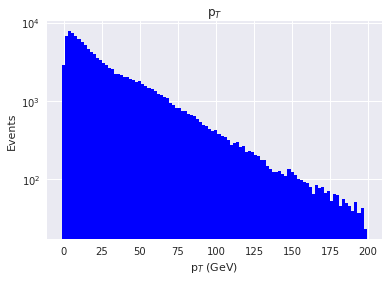

In [35]:
%matplotlib inline
# import seaborn as sbn
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql

ZmmPassDF = ZmmDF.filter("Zmm.pass")    

histogrammar.sparksql.addMethods(ZmmPassDF)

#Zmass
dimuonMass = ZmmPassDF.Bin(100, 0, 200, ZmmPassDF.Zmm.mass)
dimuonMass.plot.matplotlib(name="Invariant mass", color="blue")
plt.semilogy()
plt.xlabel('m$^{\mu\mu}$ (GeV)')
plt.ylabel('Events')
plt.show()

#ZdPhi
dimuondPhi = ZmmPassDF.Bin(64, -3.2, 3.2, ZmmPassDF.Zmm.dPhi)
dimuondPhi.plot.matplotlib(name="$\Delta\phi$", color="blue")
plt.xlabel('$\Delta\phi(\mu\mu)$')
plt.ylabel('Events')
plt.show()

#Zpt
dimuonPt = ZmmPassDF.Bin(100, 0, 200, ZmmPassDF.Zmm.pt)
dimuonPt.plot.matplotlib(name="p$_T$", color="blue")
plt.semilogy()
plt.xlabel('p$_{T}$ (GeV)')
plt.ylabel('Events')
plt.show()


# Draw plots subdivided per sample

TODO -> weight and stack

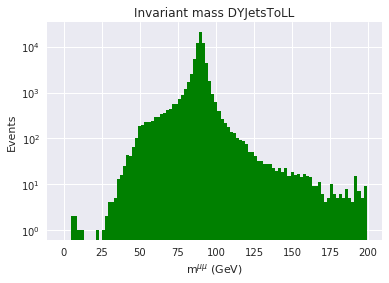

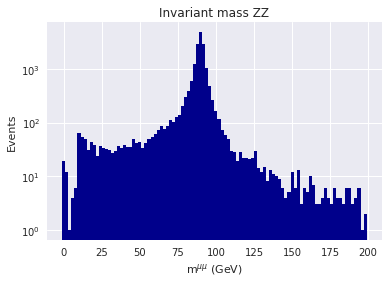

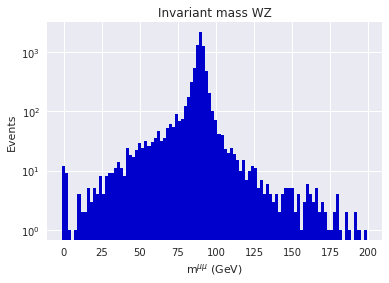

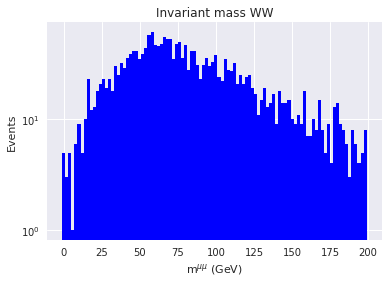

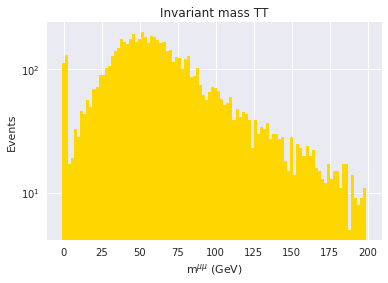

In [38]:
import numpy as np

orderedsamples = [
    'DYJetsToLL',
    'ZZ',
    'WZ',
    'WW',
    'TT',
#     'SingleMuon',    
]

dimuonMassPerSample = {}
dataframePerSample = {}

for theSample in orderedsamples:
    #Zmass
    dataframePerSample[theSample] = zmmpassDF.filter(zmmpassDF['sample']==theSample)
    histogrammar.sparksql.addMethods(dataframePerSample[theSample])
    dimuonMassPerSample[theSample] = dataframePerSample[theSample].Bin(100, 0, 200, dataframePerSample[theSample].Zmm.mass)
    if not 'SingleMuon' in theSample: 
        dimuonMassPerSample[theSample].plot.matplotlib(
            name="Invariant mass {}".format(theSample), 
            color=samples[theSample]['color'],
        )
    plt.semilogy()
    plt.xlabel('m$^{\mu\mu}$ (GeV)')
    plt.ylabel('Events')
    plt.show()
